# Feature Engineering and Modelling

---

1. Import packages
2. Load data
3. Modelling
4. Analysis
5. Implication of findings

---

## 1. Import packages

In [1]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

# ML
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import classification_report
import pickle
from sklearn.inspection import PartialDependenceDisplay

In [3]:
# Running on google collab environment
# this gives access to google drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [4]:
# sets the working directoy to a specific folder in google drive
%cd "/content/drive/My Drive/prgrmmng/job_tests/forage/bcg/task_4"

/content/drive/My Drive/prgrmmng/job_tests/forage/bcg/task_4


---
## 2. Load data

In [7]:
# loads the data
df = pd.read_csv('data/data_for_predictions.csv')
df.drop(columns=["Unnamed: 0"], inplace=True)

To improve readability, we replace the prefixes `_var` and `_fix` with `_energy` and `_power`, respectively.

In [8]:
# Function to replace suffixes in column names
def replace_suffixes(col_name):
    # Check if '_var' suffix exists in the column name
    if '_var' in col_name:
        # Replace '_var' with '_energy' if found
        return col_name.replace('_var', '_energy')
    # Otherwise, check if '_fix' suffix exists
    elif '_fix' in col_name:
        # Replace '_fix' with '_power' if found
        return col_name.replace('_fix', '_power')
    # If no replacements apply, return the original column name
    else:
        return col_name

# Applying the function to each column name
df.columns = [replace_suffixes(col) for col in df.columns]

---

## 3. Modelling

We start training our predictive model, which is the `Random Forest` classifier based on the implementation `sklearn.ensemble.RandomForestClassifier`.

### Data sampling

The first thing we do is split our dataset into training and test samples. We use a 75-25% split between train and test, respectively.

Moreover, the table below reveals an uneven distribution of the `churn` variable: a mean of 0.097 indicates that approximately 9.7% of cases are True [1] (customers who churned), while the remaining 90.3% are False [0] (customers who didn't churn). This imbalance in our target variable requires special consideration when splitting the dataset. To ensure our model training and evaluation are representative of the entire dataset, we need to use stratified sampling when creating our training and test subsets. This technique maintains the same proportion of churned to non-churned cases in both subsets as in the original dataset.

In [11]:
# Make a copy of our data
train_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])
print(X.shape)
print(y.shape)
# descriptive statistics of the target variable
y.describe()

(14606, 61)
(14606,)


count    14606.000000
mean         0.097152
std          0.296175
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: churn, dtype: float64

After splitting the data, we can see that stratified sampling ensures that the proportions of positive and negative cases of `churn` in our entire dataset are reflected in both train and test samples.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25, # relative size of test sample
    stratify=y, # variable guiding stratified sampling
    random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)
print("Proportion of positive cases in train sample",round(y_train.describe()["mean"],4))
print("Proportion of positive cases in test sample",round(y_test.describe()["mean"],4))

(10954, 61)
(10954,)
(3652, 61)
(3652,)
Proportion of positive cases in train sample 0.0971
Proportion of positive cases in test sample 0.0972


### Model training

We now train of `Random Forest`classification model. This includes selecting the most optimal set of hyper parameters. Below we can the see the range of parameters that can be adjusted.

In [ ]:
RandomForestClassifier().get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

We focus on four hyper-parameters, which are closely related to the model's underlying core assumptions (for further reference, see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)):
- criterion: Function implemented to measure the quality of a split.
- max_features: Number of features to consider when looking for the best split in terms of the total number of features. E.g., if `None` then `max_features=n_features`, while `sqrt` indicates `max_features=sqrt(n_features)`.
- bootstrap: Whether bootstrap samples are used when building trees; when False, whole dataset is used.
- oob_score: Whether to use out-of-bag samples to estimate the generalization score (see [example](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)). In this case, we set two possible combinations, since out of bag estimation only available if `bootstrap=True`.

In [ ]:
# Define a list of parameter grids
param_grid_list = [
    {"criterion": ["gini", "entropy", "log_loss"],
     "max_features":["sqrt", "log2", None],
     "bootstrap":[True],
     "oob_score":[False, True]},
    {"criterion": ["gini", "entropy", "log_loss"],
     "max_features":["sqrt", "log2", None],
     "bootstrap":[False]}
    ]

In [ ]:
# Create a Random Forest Classifier with a fixed random state
rf_model = RandomForestClassifier(random_state=42)
# Perform Grid Search Cross-Validation with 5-fold CV
rf_model = GridSearchCV(rf_model, param_grid=param_grid_list,cv=5)
# Train the model with the training data
rf_model.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'bootstrap': [True],
                          'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2', None],
                          'oob_score': [False, True]},
                         {'bootstrap': [False],
                          'criterion': ['gini', 'entropy', 'log_loss'],
                          'max_features': ['sqrt', 'log2', None]}])

In [ ]:
# Print the best hyperparameters and best score found by GridSearchCV
print("Optimal hyperparameters: "+str(rf_model.best_params_))
print("Best score: "+str(rf_model.best_score_)+"\n")
# Show the top results (rank 1) from the GridSearchCV
scores = pd.DataFrame(rf_model.cv_results_).sort_values(by=["rank_test_score"])
scores[scores["rank_test_score"]==1].head()

Optimal hyperparameters: {'bootstrap': True, 'criterion': 'entropy', 'max_features': None, 'oob_score': False}
Best score: 0.9076135039774587



,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_features,param_oob_score,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,26.074330,1.245051,0.050105,0.000770,True,log_loss,None,True,"{'bootstrap': True, 'criterion': 'log_loss', '...",0.912369,0.905523,0.906435,0.907805,0.905936,0.907614,0.002499,1
16,25.577655,0.843060,0.060061,0.010087,True,log_loss,None,False,"{'bootstrap': True, 'criterion': 'log_loss', '...",0.912369,0.905523,0.906435,0.907805,0.905936,0.907614,0.002499,1
10,25.616131,1.089018,0.050906,0.002287,True,entropy,None,False,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.912369,0.905523,0.906435,0.907805,0.905936,0.907614,0.002499,1
11,25.755483,0.749521,0.053765,0.004727,True,entropy,None,True,"{'bootstrap': True, 'criterion': 'entropy', 'm...",0.912369,0.905523,0.906435,0.907805,0.905936,0.907614,0.002499,1


In [ ]:
# Save the GridSearchCV object to a pickle file for later use
with open('rf_models_gridCV_bcg.pkl','wb') as f:
    pickle.dump(rf_model,f)

### Evaluation of model's performance
#### Performance metrics
We now evaluate how well the best trained model is able to predict the values of the test dataset.

In [13]:
# Load the GridSearchCV object to continue analysis
with open('rf_models_gridCV_bcg.pkl', 'rb') as f:
    rf_gridCV = pickle.load(f)

In [14]:
# Get the best estimator (model) from the loaded GridSearchCV object
rf_model_best = rf_gridCV.best_estimator_
# Make predictions on the test data using the best model
prediction = rf_model_best.predict(X_test)

First. we evaluate our model's predictions using a confusion matrix, which categorizes results into True/False Positive/Negative cases. These categories compare the model's predictions to the actual outcomes, allowing us to assess both correct and incorrect classifications. Specifically, True Positive (TP) and True Negative (TN) refers to the correct prediction of positive and negative outcomes, respectively. Similarly, False Positive (FP) and False Negative (FN), refers to incorrect predictions of positive and negative outcomes, respectively.

For context:
- Class 1 represents customers who churned
- Class 0 represents customers who did not churn

The confusion matrix below reveals some interesting insights on our model's performance. While it successfully classified a significant portion of cases, there are areas for improvement. The model excelled at correctly identifying non-churning customers (class 0) with 3284 True Negatives (TNs). However, it struggled with churning customers (class 1). It missed identifying 320 cases (False Negatives, FN) and incorrectly classified 13 non-churning customers as churn (False Positives, FP).

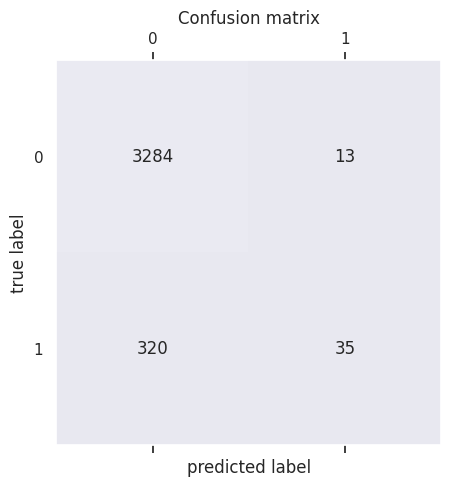

In [15]:
# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test,prediction)
# Create a figure and axes for plotting
ig, ax = plt.subplots(figsize=(5, 5))
# Plot the confusion matrix as a heatmap
# with grayscale colors and low transparency
ax.matshow(conf_matrix, cmap='gray', alpha=0.01)
# Loop through each cell of the confusion matrix
# and add its value as text to the plot
for i in range(conf_matrix.shape[0]): # rows
  for j in range(conf_matrix.shape[1]): # columns
    ax.text(x=j,
            y=i,
            # Text content is the value at position [i, j]
            s=conf_matrix[i, j],
             # Align text in the center of the cell
            va='center', ha='center')
# Remove grid lines for better visualization
ax.grid(False)
# Add labels and title for the plot
plt.title("Confusion matrix")
plt.xlabel('predicted label')
plt.ylabel('true label')
# Display the plot
plt.show()

To gain a better understanding of our model's performance, we examine the above metrics but now in terms relative to the size of our test sample. Given the unbalanced nature of our data, we focus on the model's performance for each class separately, rather than its overall accuracy across both classes. In this context, `precision` denotes the percentage of correctly classified cases (TP) out of all cases classified in a given class (TP + FP). In contrast, `recall` indicates the percentage of correctly classified cases (TP) out of all actual positive cases in the test sample (TP + FN), which is also known as the "true positive rate" ([Raschka & Mirjalili](https://www.google.com/search?q=Raschka+%26+Mirjalili++2017+Python+Machine+Learning), 2017: 322). These metrics provide a more detailed view of our model's performance, which proves relevant for imbalanced datasets like ours.

We focus on our class of interest: identifying positive churn cases. The `classification report` below shows that our model has a `precision` of 73%, but a `recall` of 10%. This suggests that our model is on target when it predicts churn, but it misses many actual churn cases. Specifically:

1. High Precision (73%): When our model predicts a customer will churn, it's correct about 73% of the time. This indicates good reliability for positive predictions.

2. Low Recall (10%): Our model is only identifying 10% of all actual churn cases. This means it's failing to flag many customers who do end up churning.

In short, the large gap between precision and recall indicates that our model is too conservative in making churn predictions. It's prioritizing avoiding false positives at the cost of missing many true positives.

In [16]:
# Evaluate the predictions using the classification_report function
report = classification_report(y_test, prediction)
# Print the classification report
print("Classification report:")
print(report)

Classification report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3297
           1       0.73      0.10      0.17       355

    accuracy                           0.91      3652
   macro avg       0.82      0.55      0.56      3652
weighted avg       0.89      0.91      0.88      3652



#### Implications: Applicability in real-world settings.

Our model's performance analysis reveals key limitations for real-world applications. The low true positive rate (`recall`) suggests that the model often fails to identify relevant cases, limiting its practical value in business settings. Although the model demonstrates high precision by rarely making incorrect churn predictions, it fails to identify 90% of churning customers. This significantly limits the model's ability to provide actionable insights for preventing churn, as it fails to flag a large number of at-risk customers.

Moving forward, the primary focus for Data & ML team should be on improving the model's ability to identify a larger number of potential churners, even if it comes at the cost of slightly reduced precision. This approach reflects the well-known bias-variance trade-off in ML and statistics. Typically, ML practitioners must choose between models exhibiting high bias & low variance (resulting in low recall with high precision) or those with low bias & high variance (yielding high recall with lower precision), as ideal conditions are rarely achievable. Addressing this challenge involves exploring various techniques, such as alternative estimation methods (e.g., Logistic Regression), adjusting classification thresholds, or refining feature selection by either dropping less informative features or incorporating more predictive ones. These strategies could potentially lead to a more effective model for predicting customer churn.

---

## 4. Analysis

### Main findings

#### Which features are more important?

In this section, we examine the validity of our initial hypothesis that price is the primary driver of customer churn. Our findings reveal a different picture, where non-price factors seem to play more important roles in predicting churn probability.

In [17]:
# Create a DataFrame to store feature importances
feature_importance = pd.DataFrame({
    # Get feature names
    'feature': X_train.columns,
    # Get feature importances
    'importance': rf_model_best.feature_importances_
  # Sort by importance descending and reset index
  }).sort_values(by = ['importance'],ascending=False).reset_index()

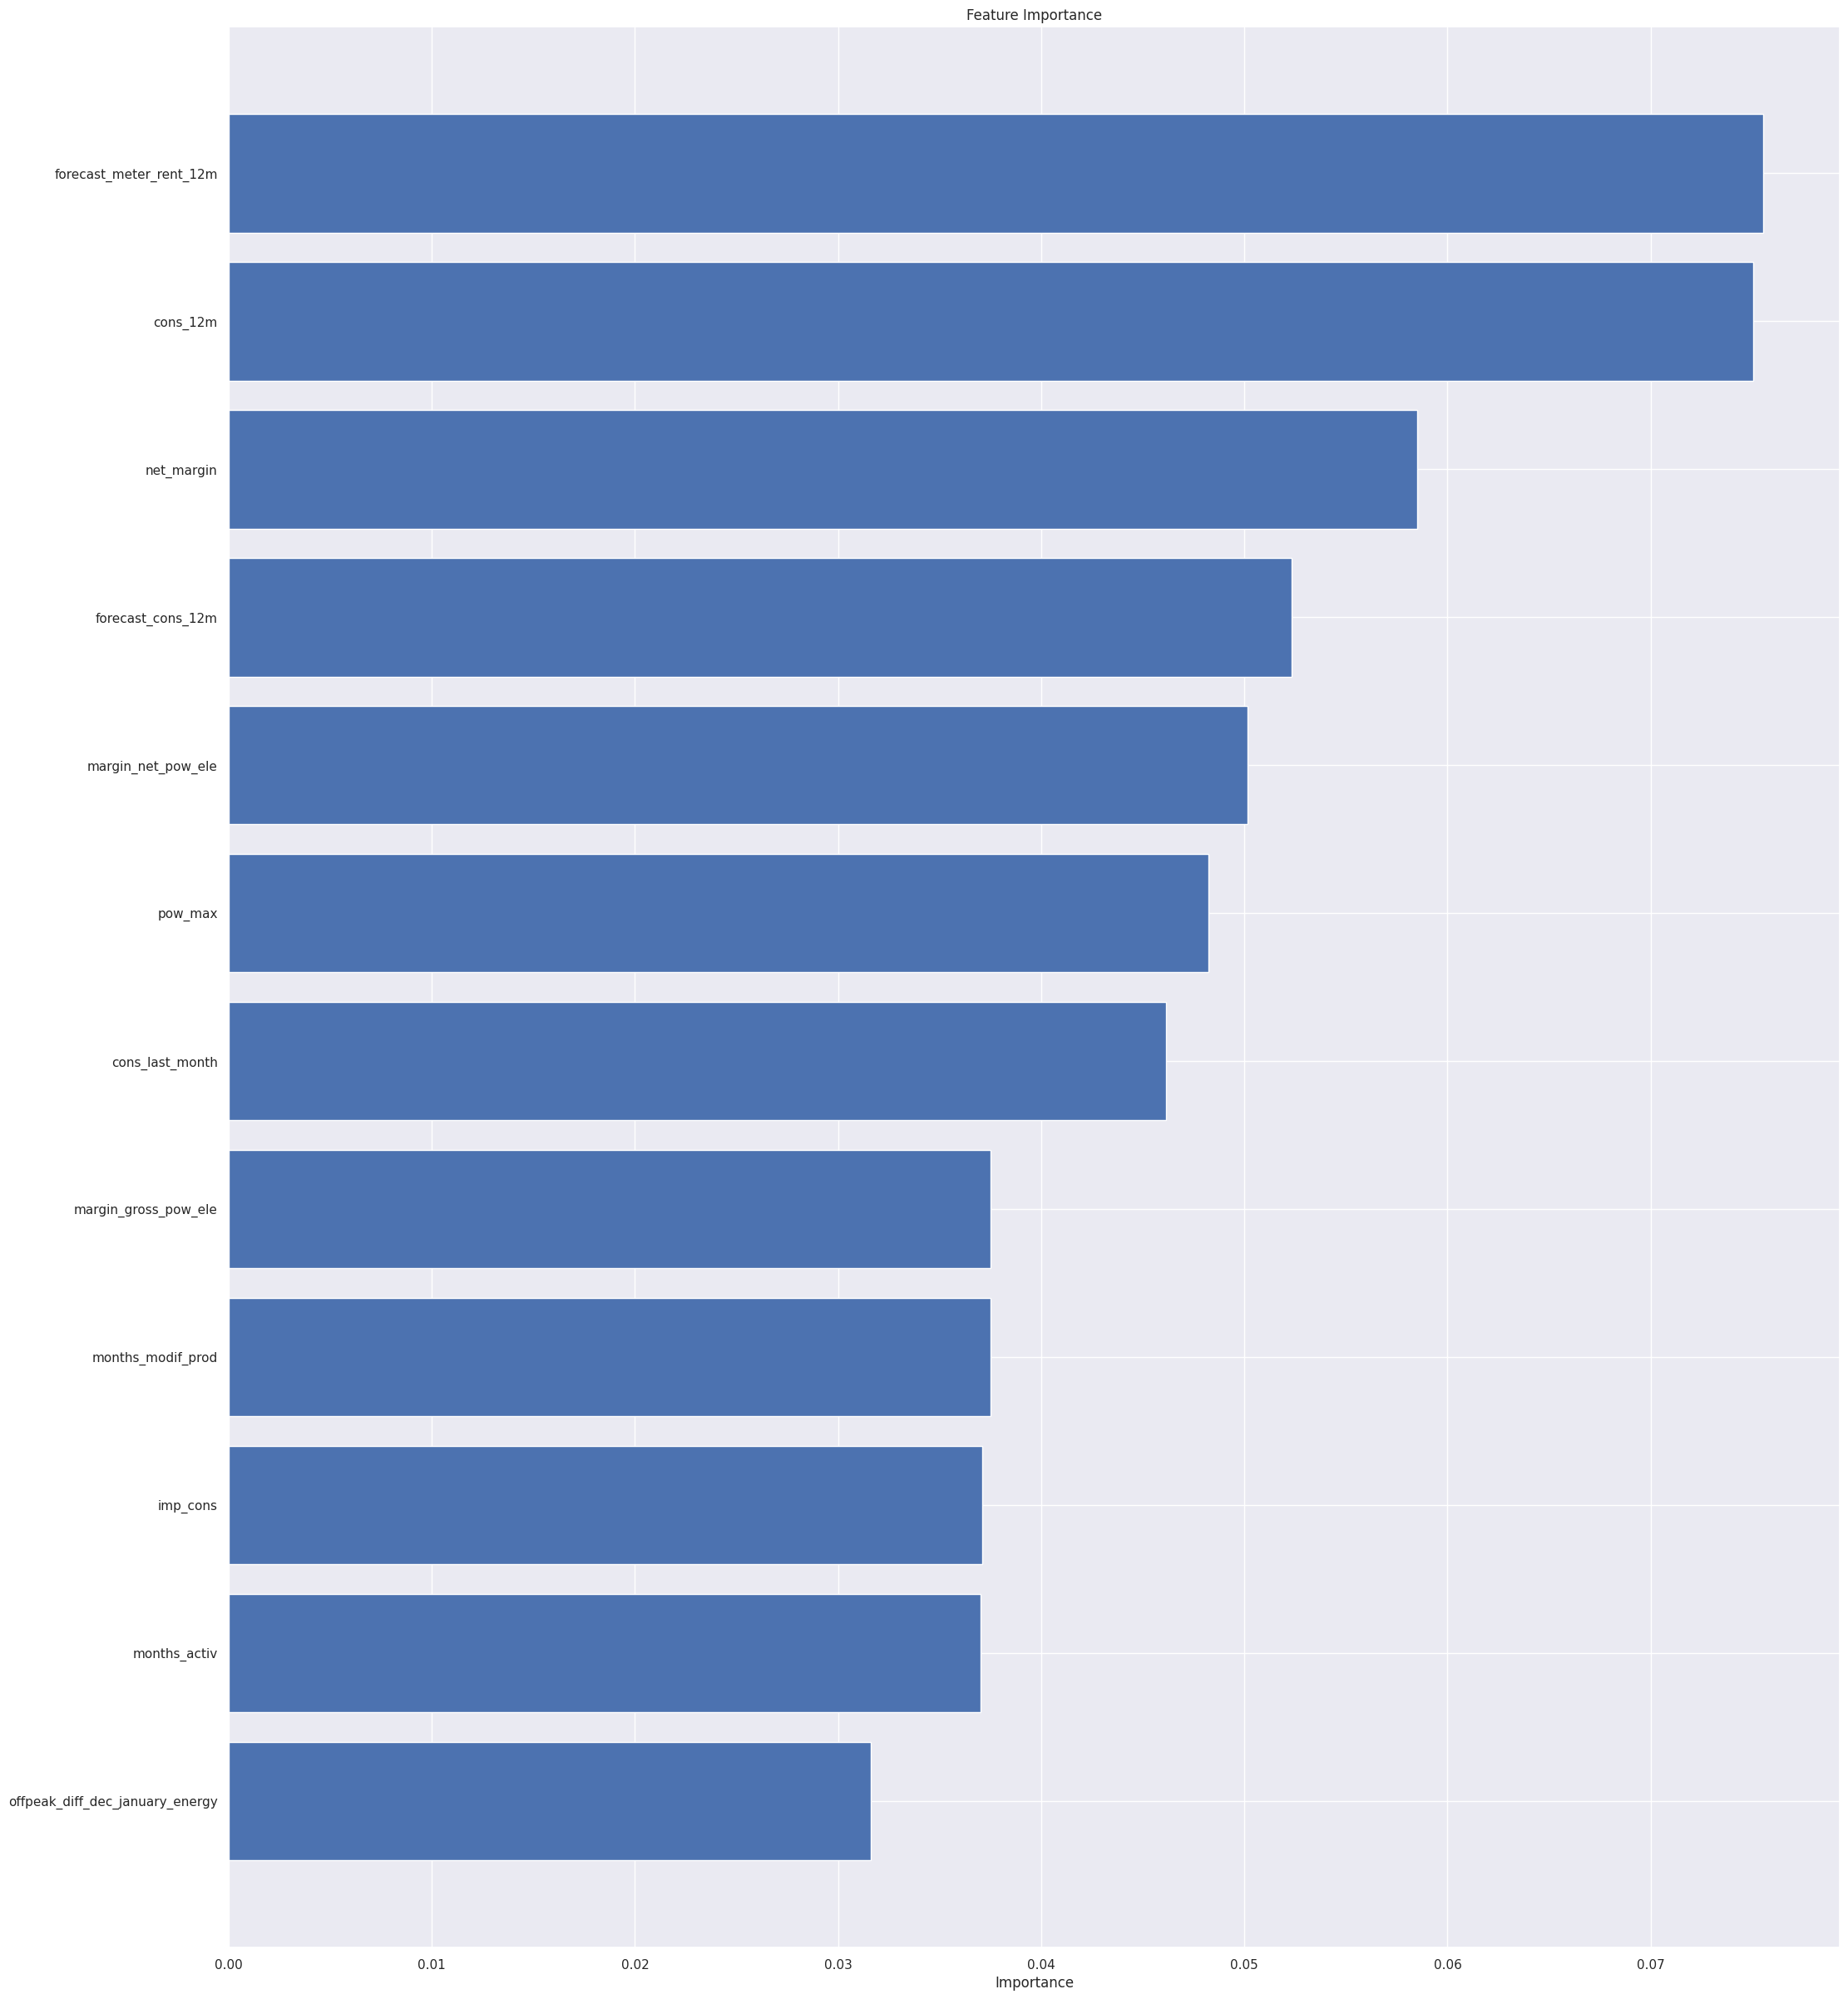

In [18]:
# Calculate the number of features to display (top 20%)
len_half_features = int(len(feature_importance)*0.2)
# Select the top 20% features based on importance
feature_importance_plot = feature_importance[:len_half_features]
# Sort the features by importance in descending order
feature_importance_plot = feature_importance_plot.sort_values(by = ['importance']).copy()
# Set the figure size for better visualization
plt.figure(figsize = (25,30))
# Set plot title
plt.title("Feature Importance")
# Create a horizontal bar chart
plt.barh(range(len(feature_importance_plot)), feature_importance_plot['importance'], align = 'center' )
# Set labels on the y-axis
plt.yticks( range(len(feature_importance_plot)), feature_importance_plot['feature'] )
# Label the x-axis
plt.xlabel('Importance')
# Display the plot
plt.show()

#### Do price-related factors drive customer churn?
We now evaluate our initial working hypothesis that price-related factors are the primary drivers of customer churn. To do this, we compare the joint `feature importance` of price-related factors versus non-price factors in predicting churn.

`Feature importance` measures how much each variable contributes to the model's predictions, quantifying its impact on the classification process. We calculate the joint importance as the cumulative sum of price-related features and non-price features separately, then compare these sums to determine which group has a greater influence on churn probability.

To set the stage, the table below shows the joint contribution of the top-10 features. Jointly, these top features contribute to 50% of the churn probability. That is, our model suggests that half of the predictive power for determining whether a customer will churn comes from these top 10 variables out of the 61 variables included in our model.

In [19]:
feature_importance["aggregate_contribution"] = feature_importance["importance"].cumsum()
print("Most important feature: Top 10")
feature_importance.head(10)

Most important feature: Top 10


,index,feature,importance,aggregate_contribution
0,5,forecast_meter_rent_12m,0.075545,0.075545
1,0,cons_12m,0.075032,0.150578
2,14,net_margin,0.058503,0.209081
3,3,forecast_cons_12m,0.052334,0.261415
4,12,margin_net_pow_ele,0.050159,0.311574
5,15,pow_max,0.048216,0.359790
6,2,cons_last_month,0.046145,0.405935
7,11,margin_gross_pow_ele,0.037510,0.443444
8,51,months_modif_prod,0.037486,0.480930
9,10,imp_cons,0.037106,0.518036


Comparing price-related and non-price factors reveals an interesting landscape. Non-price factors dominate the top predictors of customer churn. Specifically:

1. Price-related factors: Contribute ~34% to the model's predictions.
2. Non-price factors: Account for the remaining ~66% of the model's predictions.

This distribution challenges our initial hypothesis, which focused primarily on price-related factors. The results suggest that customer churn is more significantly influenced by non-price factors than initially assumed.

In [29]:
feature_importance_price = feature_importance.loc[
    feature_importance["feature"].str.contains("price|diff")].copy()
feature_importance_price["aggregate_contribution"] = feature_importance_price["importance"].cumsum()
print(f"Total contribution by type of factor (%), from a total of {len(feature_importance)} features:")
print(f"1. All price-related factors ({len(feature_importance_price)} features):",
    round(feature_importance_price["aggregate_contribution"].max(), 3) * 100,"%")
print(
    f"2. All non-price factors ({len(feature_importance)-len(feature_importance_price)} features):",
     (1 - round(feature_importance_price["aggregate_contribution"].max(), 3))* 100,"%")

Total contribution by type of factor (%), from a total of 61 features:
1. All price-related factors (35 features): 34.1 %
2. All non-price factors (26 features): 65.9 %


In conclusion, these estimates from our Random Forest model do not provide evidence that price-related factors are the primary drivers of customer churn across our entire sample. Alternatively, our model's estimates suggests that non-price factors play a more significant role in determining customer churn. To gain a better understanding of these findings, the following section examines the relationships between price-related factors, non-price factors, and customer churn in greater detail.

#### How is the relation between non-price and price-related factors with our target variable?

Although `feature importance` in Random Forest models shows which variables have the strongest influence on predictions, it doesn't reveal how these features relate to the target variable (churn probability). To understand better these relationships, we plot `partial dependence`. Partial dependence plots show how the target variable (churn probability) changes according to one feature, while keeping all others constant (see [documentation](https://scikit-learn.org/stable/modules/partial_dependence.html)). Therefore, these plots help us visualize the expected impact of a single feature on the model's predictions. We create partial dependence plots for:
1. The top 3 most important non-price features:
    - "forecasted bill of meter rental" (`forecast_meter_rent_12m`).
    - "past yearly electricity consumption" (`cons_12m`).
    - The third important feature, "total net margin" (`net_margin`).

2. The top 3 most influential price-related factors:
    - "yearly price energy difference" (`offpeak_diff_dec_january_energy`).
    - "average off peak price" (`var_year_price_off_peak`).
    - "average off peak and peak difference of energy prices" (`off_peak_peak_energy_mean_diff`).

In [ ]:
cols_nonprice_top3 = feature_importance["feature"][:3].tolist()
feature_importance.head(3)

,index,feature,importance,aggregate_contribution
0,5,forecast_meter_rent_12m,0.075545,0.075545
1,0,cons_12m,0.075032,0.150578
2,14,net_margin,0.058503,0.209081


In [ ]:
cols_price_top3 = feature_importance_price["feature"][:3].tolist()
feature_importance_price.head(3)

,index,feature,importance,aggregate_contribution
11,34,offpeak_diff_dec_january_energy,0.031624,0.031624
12,22,var_year_price_off_peak,0.029916,0.061540
13,36,off_peak_peak_energy_mean_diff,0.028136,0.089676


The partial dependence plots for these variables will help us understand how each of these features affects the likelihood of customer churn.

##### Non-price factors
Random Forest model reveals that the top three non-price features are key indicators of customer churn, challenging our initial assumption that price was the primary factor. Examining the plots, we observe that two of these non-price factors exhibit complex, non-linear relationships with churn probability. In contrast, the third factor shows a more straightforward linear relationship. Interpreting these non-linear relationships is tricky; it requires careful analysis of specific sections within the data, as the relation with churn probability varies across different ranges of these features.

1. The first plot focuses on the most important feature: "forecasted bill of meter rental" (`forecast_meter_rent_12m`), which can be interpreted as a proxy for the size of the user-company. While it is a bill-related factor, it indirectly captures more than just the aggregate cost of meter rental: higher values suggest larger companies renting more meter units. The relationship between company size and churn probability remains relatively stable across most of the range. However, as companies approach the upper limit of size, as signaled by the highest forecasted meter rental bills, there is a notable increase in churn probability. This suggests that the largest companies in the dataset are more likely to discontinue their service compared to their smaller counterparts.

2. The second most important feature, "past yearly electricity consumption" (`cons_12m`), also signals the size of user-companies but based on level of consumption. The relationship between yearly service consumption and churn probability is predominantly inverse, but contains important non-linear elements. Churn probability initially decreases as consumption increases, which suggests smaller customers are more prone to churning. However, this trend reverses in the middle consumption range, where churn probability begins to rise again. This indicates a higher churn risk among mid-sized to larger customers. The pattern continues into the highest consumption levels, with several smaller fluctuations visible. These variations reveal that the connection between consumption and churn is not uniformly linear, but varies across different customer segments according to their service usage.

3. The third important feature, "total net margin" (`net_margin`), also provides an indrect signal of the size of user-companies. Larger companies with higher consumption likely contribute more to PowerCo's net margin. The marked positive linear relationship suggests that high-value customers are at a greater risk of churning, possibly due to more competitive offers and greater bargaining power when negotiating contracts with other providers.

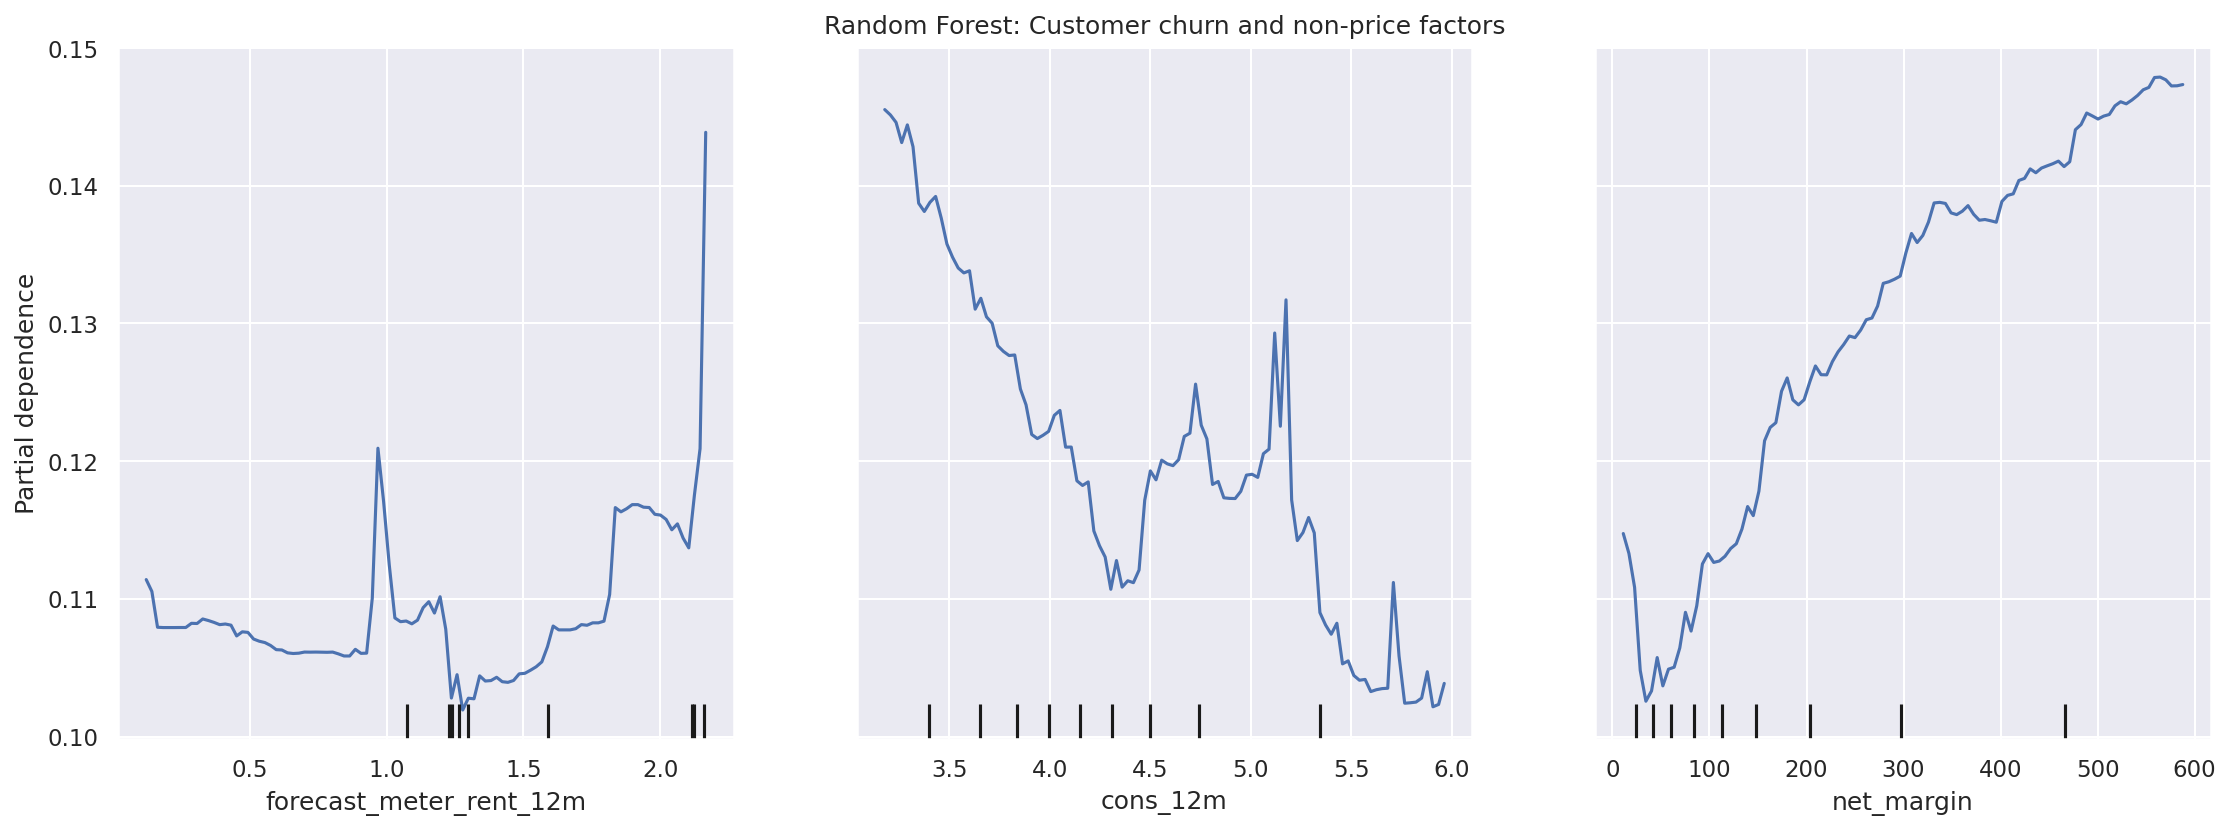

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6), dpi=150)
ax.set_title("Random Forest: Customer churn and non-price factors")
pdp_nonprice_top3 = PartialDependenceDisplay.from_estimator(
    rf_model_best, X,
    features=cols_nonprice_top3
    #,feature_names=["cons_12m"]
    ,ax=ax
    )

In conclusion, the analysis of the top three non-price features reveals that churn probability varies significantly across different customer segments. Smaller user-companies generally exhibit lower churn probabilities, while larger (forecasted meter rental bills) and high-value (total net margin) customers are at a greater risk of churning, potentially due to attractive offers from competitors and more bargaining power. However, the relationship between yearly service consumption and churn displays a more complex, non-linear relationship, where churn risk decreases with consumption levels initially, but an increased risk is then observed in mid-sized to larger consumption levels. Jointly, these findings suggest that large, high-value user-companies are most likely to churn, but smaller to mid-size user-companies exhibit substantial heterogeneity, which could be influenced by varying unobserved factors, such as customer service experiences or regional market conditions, that require further research.

It's important to note that our model has some limitations, so there could be interactions between these features that aren't immediately apparent Additionally, other factors not captured in these top features might also play significant roles in churn decisions. Further analysis of feature interactions and the inclusion of other variables could provide a more comprehensive understanding of the main factors affecting churn across different customer segments.

##### Price-related factors

In contrast to non-price factors, most price-related factors do not signal customer characteristics but, rather, churn sensitivities to price changes.  Two of these factors exhibit non-linearity in the relationship with customer churn.

1. The first plot focuses on "yearly price energy difference" (`offpeak_diff_dec_january_energy`). The plot shows a slightly linear relationship, although there are fluctuations that indicate a complex relationship between this feature and the churn probability, or just uncertainty in our model's estimates. The decrease in churn probability as the difference approaches zero from negative values suggests that there might be some price stability, which the customer might find positive, therefore, decreasing the risk of churning.

2. The second plot is concerned with "average off-peak price" (`var_year_price_off_peak`). There is a clear overall trend, where as the price increases, the probability of churn also increases, though not uniformly. The initial drop might just suggest customers not using the service, but further domain knowledge on the pricing structure is needed. Yet, towards the end there is a dramatic increase in churn probability, indicating a possible price threshold where many customers become significantly more likely to churn. After this sharp rise, the churn probability levels off, suggesting that any additional price increases don't substantially affect churn likelihood.

3. The third plot shows a non-linear relationship between "average off-peak and peak difference of energy prices" (`off_peak_peak_energy_mean_diff`). The flat regions indicate that small changes in the price difference have little effect on churn probability in these ranges. In contrast, the sharp drops in churn probability suggests that when price differences exceed these thresholds, the likelihood of churn decreases significantly.

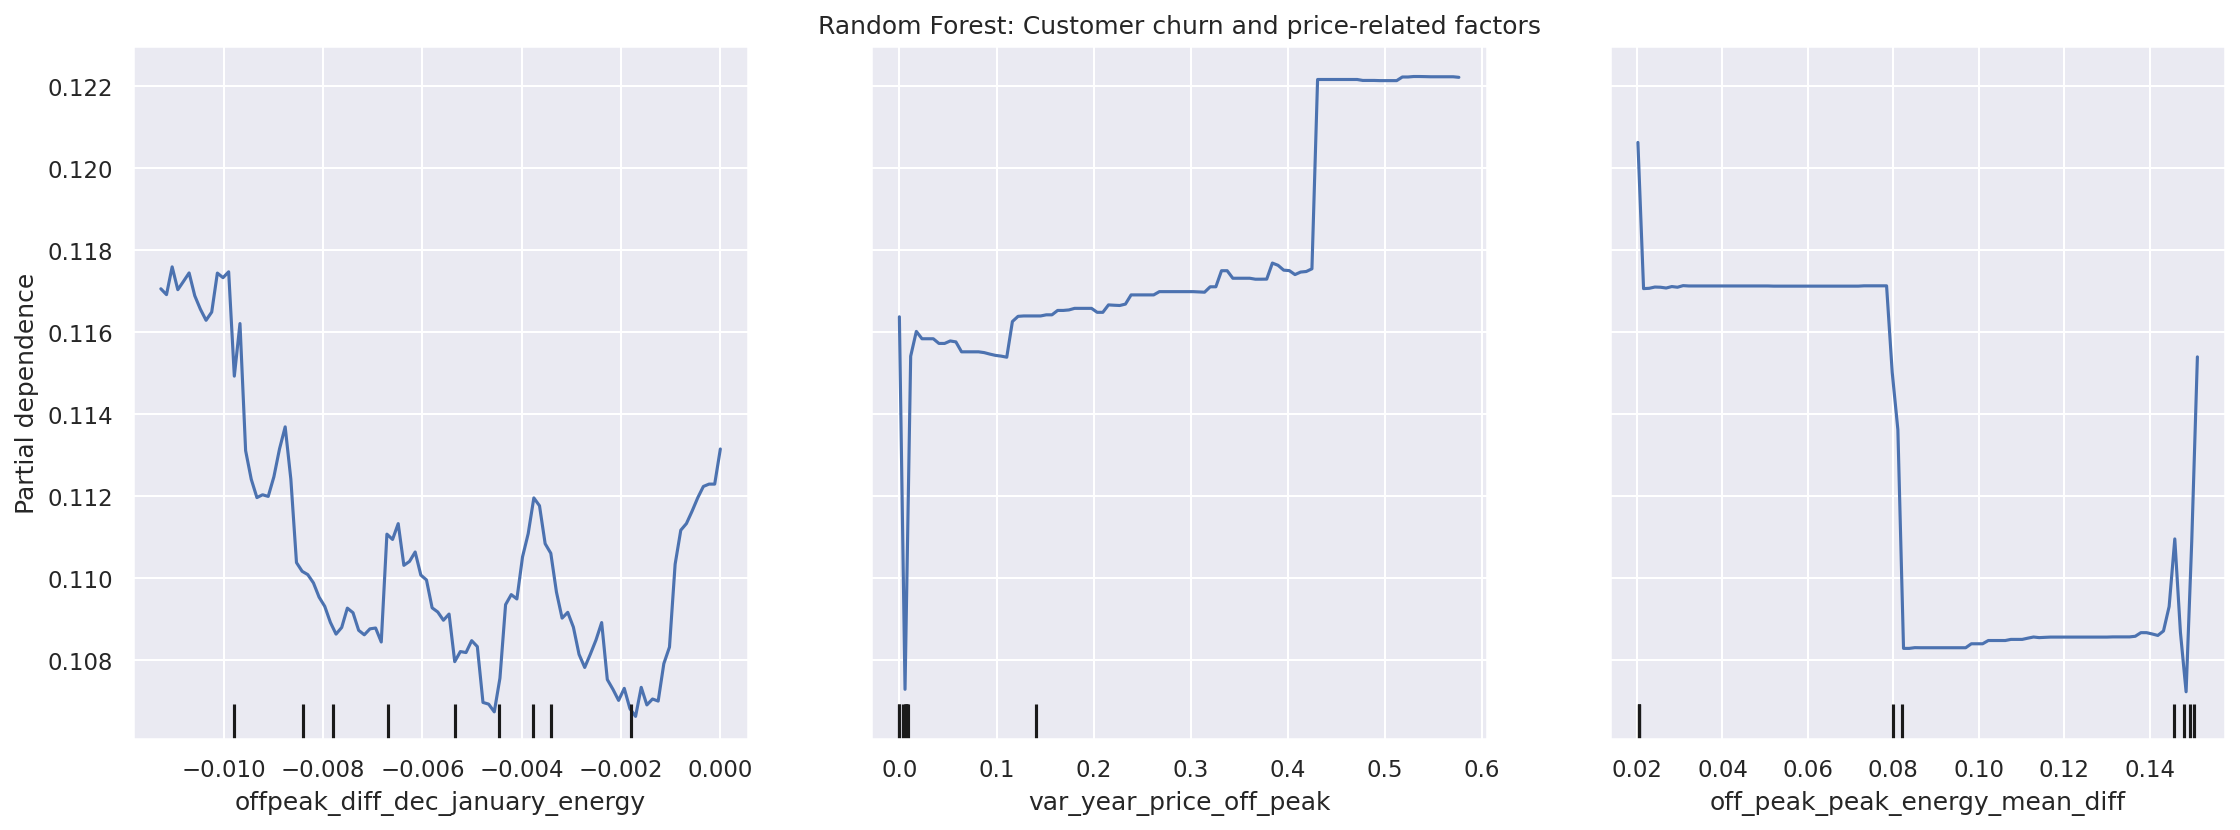

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6), dpi=150)
ax.set_title("Random Forest: Customer churn and price-related factors")
pdp_price_top3 = PartialDependenceDisplay.from_estimator(
    rf_model_best, X,
    features=cols_price_top3
    #,feature_names=["offpeak_diff_dec_january_energy"]
    ,ax=ax
    )

In conclusion, price-related factors, although not the most important features on our model, display complex, non-linear relationships with customer churn probability. While some factors show relatively linear trends, others exhibit important thresholds that significantly affect churn probability. These patterns suggest that customer retention is influenced by various aspects of pricing, including price stability and other factors related to the pricing structure.

---

## 5. Implications of findings

### Key findings

1. **Price is not the main determinant of churn across customers**:
    - Price-related factors account for about ~34% of the important factors that our model uses to make predictions.
    - Non-price factors account for the remaining ~66%.

2. **Non-price factors suggest significant variability across customer segments**:
    - Large and high-value customers seem more susceptible to churning, possibly due to their higher sensitivity to competitive offerings and greater bargaining power when negotiating contracts with other providers.
    - Smaller companies have different chances of leaving, possibly affected by unobserved factors (e.g., customer service experiences or regional market conditions).

3.  **Complex relationships between price and churn**:
    - While Price-related factors are less important, they exhibit complex, non-linear relationships with the likelihood of customer churn, highlighting the role of price stability and pricing structures.

### Practical implications of findings: Targeted retention strategies
- A targeted retention strategy for large and high-value customers may be beneficial.
- More research is needed to inform a targeted strategy for smaller customers.


### Further research:
- **Understand price sensitivities**: Investigate how different customer segments respond to price changes and what price structures are most effective in reducing churn.
- **Explore additional non-price factors**: e.g., customer service quality, product satisfaction, and market conditions.

A comprehensive analytical approach considering price and non-price factors will likely yield the most relevant insights to help build an effective churn prevention strategy across segments.